# Jupyter Comment Clusters
### (K-Means Clustering)

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
df = pd.read_csv('issue_comments_jupyter_copy.csv')
df['org'] = df['org'].astype('str')
df['number'] = df['number'].astype('str')
df['repo'] = df['repo'].astype('str')
df['comments'] = df['comments'].astype('str')
df['user'] = df['user'].astype('str')

Add stopwords into the vectorizer and bring max_df down to focus on the center of the cluster

In [40]:
import lda
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 20 # number of topics
n_iter = 500 # number of iterations
#circling back to add stop words
stopwords = text.ENGLISH_STOP_WORDS.union(['want', 'need', 'python', 'ipython', 'use', 'using', 'user',
                                           'way', 'cell', 'kernel', 'think','git','jupyter', 'notebook', 
                                           'https', 'github', 'com', 'html', 'http', 'org','ellisonbg','don',
                                           'brian', 'granger', 'things', 'like', 'thanks', 'just', 'tried', 'minrk',
                                          'issue', 'issuecomment'])


for repo, repo_df in df.groupby('repo'):
    if repo == 'notebook':
        # vectorizer: ignore English stopwords & words that occur less than 5 times
        all_comments = []
        for issue, comment_df in repo_df.groupby('number'):
            all_comments.append(' '.join(comment_df['comments'].values))

        cvectorizer = CountVectorizer(min_df=5, max_df=0.5, stop_words=stopwords)
        cvz = cvectorizer.fit_transform(all_comments)
        #vocab = {v: k for k, v in cvectorizer.vocabulary_.iteritems()}
        vocab = cvectorizer.get_feature_names()
        # train an LDA model
        lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
        #lda_model = models.LdaModel( matutils.Sparse2Corpus(cvz, documents_columns=False), num_topics=n_topics, passes=n_iter, id2word = vocab)
        X_topics = lda_model.fit_transform(cvz)
        break

INFO:lda:n_documents: 2051
INFO:lda:vocab_size: 4091
INFO:lda:n_words: 245236
INFO:lda:n_topics: 20
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -2812980
INFO:lda:<10> log likelihood: -2027443
INFO:lda:<20> log likelihood: -1946706
INFO:lda:<30> log likelihood: -1918759
INFO:lda:<40> log likelihood: -1903815
INFO:lda:<50> log likelihood: -1893372
INFO:lda:<60> log likelihood: -1885784
INFO:lda:<70> log likelihood: -1879727
INFO:lda:<80> log likelihood: -1875726
INFO:lda:<90> log likelihood: -1871015
INFO:lda:<100> log likelihood: -1866717
INFO:lda:<110> log likelihood: -1863416
INFO:lda:<120> log likelihood: -1861918
INFO:lda:<130> log likelihood: -1860489
INFO:lda:<140> log likelihood: -1858436
INFO:lda:<150> log likelihood: -1856222
INFO:lda:<160> log likelihood: -1856424
INFO:lda:<170> log likelihood: -1854185
INFO:lda:<180> log likelihood: -1853733
INFO:lda:<190> log likelihood: -1852581
INFO:lda:<200> log likelihood: -1851246
INFO:lda:<210> log likelihood: -1850140
INFO:lda:<

In [47]:
#lda_model.print_topics(num_topics=5, num_words=5)
X_topics.shape
np.version.version



'1.13.0'

Most common words in clusters. Read through the documents to assign meaningful cluster names and label the clusters. 

### TSNE

In [48]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, angle=.8, init='pca', method='exact')

# 20-D -> 2-D
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2051
[t-SNE] Computed conditional probabilities for sample 2000 / 2051
[t-SNE] Computed conditional probabilities for sample 2051 / 2051
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 100 iterations with early exaggeration: 17.583553
[t-SNE] Error after 225 iterations: 17.583553


In [49]:
import numpy as np
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

n_top_words = 5 # number of keywords we show

# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

In [51]:
_lda_keys = []
for i in xrange(X_topics.shape[0]):
  _lda_keys +=  X_topics[i].argmax(),

In [52]:
topic_summaries = []
topic_word = lda_model.topic_word_  # all topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
  topic_summaries.append(' '.join(topic_words)) # append!

In [61]:
title = 'Jupyter Comments'
num_example = 50 #len(X_topics)

plot_lda = bp.figure(plot_width=800, plot_height=600,
                     title=title,
                     #tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
                 color=colormap[_lda_keys][:num_example],
                 source=bp.ColumnDataSource({
                   "content": all_comments[:num_example],
                   "topic_key": _lda_keys[:num_example]
                   }))

/Users/jamiew/anaconda/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Users/jamiew/anaconda/lib/python2.7/site-packages/bokeh/models/sources.py:91: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('content', 50), ('topic_key', 50), ('y', 2051)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
/Users/jamiew/anaconda/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Users/jamiew/anaconda/lib/python2.7/site-packages/bokeh/models/sources.py:91: BokehUserWarning: ColumnDataSou

GlyphRenderer(id='913b26d2-ebdc-499e-a942-b2238b16366e', ...)

In [63]:
from bokeh.io import output_notebook, show
output_notebook()

# randomly choose a news (within a topic) coordinate as the crucial words coordinate
topic_coord = np.empty((X_topics.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
  if not np.isnan(topic_coord).any():
    break
  topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

# plot crucial words
for i in xrange(X_topics.shape[1]):
  plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
#hover = plot_lda.select(dict(type=HoverTool))
#hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
#save(plot_lda, '{}.html'.format(title))
show(plot_lda)

Loading BokehJS ...

In [22]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [23]:
from sklearn.manifold import TSNE
xycoords = TSNE().fit_transform(X)

In [24]:
X.head()

,02,04,10,11,11e5,11e6,12,13,14,15,...,worth,wouldn,write,writing,wrong,wrote,www,yeah,yep,yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
xycoords.shape

(17656, 2)

In [26]:
comments.shape

(17656,)

In [27]:
colormap = [
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
]

In [28]:
import numpy as np

In [29]:
import pandas as pd

In [30]:
df = pd.DataFrame(xycoords)
df = df.rename(columns={0: 'x', 1: 'y', 2:'terms'})
df.head()

,x,y
0,3.512242e+06,5.307545e+06
1,2.082861e+06,-5.637547e+06
2,4.108872e+06,4.649874e+07
3,2.874704e+06,4.324459e+06
4,-5.411906e+06,3.982923e+05


Read this to move forward: https://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html

In [31]:
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure

source = ColumnDataSource(df)
hover = HoverTool(tooltips=[("term", "@term")])

plot3 = figure(
    plot_width=900,
    plot_height=700,
    title='Comments Map by t-SNE',
    tools='pan,wheel_zoom,box_zoom,reset,hover,previewsave'
    )

#plot.add_tools(hover)

plot3.circle(x='x', y='y', color='blue', source=source)

show(plot3)

## Import data from API call

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
df = pd.read_csv('issue_comments_jupyter_copy.csv')

df['org'] = df['org'].astype('str')
df['repo'] = df['repo'].astype('str')
df['comments'] = df['comments'].astype('str')
df['user'] = df['user'].astype('str')

## Load data into a sparse matrix

In [31]:
struct_comments = df.comments.to_sparse()

In [32]:
struct_comments.shape

(17656,)

In [34]:
struct_comments.head()

0                                           Thanks !\n
1    Oops. i got it. I have to uninstall ipython3 a...
2                                         same issue\n
3    FWIW a workaround is to share from Google Driv...
4    At some point, I'll probably hack on a Rethink...
Name: comments, dtype: object
BlockIndex
Block locations: array([0], dtype=int32)
Block lengths: array([5], dtype=int32)

- We want a matrix: rows are comments, columns are terms used
    - cells will be 1 if word exists in that comment, 0 if not
- This code takes <1 second to run 

In [6]:
%%time

user_ids = []
comment_ids = []
comment_to_id = {}
i = 0
with open ('issue_comments_jupyter_copy.csv', 'r') as f: 
    for line in f:
        for item in line.rstrip().split(',')[1:]:
            if item not in comment_to_id:
                comment_to_id[item] = len(comment_to_id)
            user_ids.append(i)
            comment_ids.append(comment_to_id[item])
        i+=1
        
import numpy as np
from scipy.sparse import csr_matrix #https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.sparse.csr_matrix.html

rows = np.array(comment_ids)
cols = np.array(user_ids)
data = np.ones((len(user_ids),))
num_rows = len(comment_to_id)
num_cols = i

#the code above exists to feed this call
adj = csr_matrix( (data, (rows,cols)), shape=(num_rows, num_cols) )
print adj.shape
print ""

# now we have our matrix, so let's gather up a bit of info about it
users_per_issue = adj.sum(axis=1).A1
comments = range(len(comment_to_id))
for item in comment_to_id:
    comments[comment_to_id[item]]=item
comments = np.array(comments)
            

(69267, 106320)

CPU times: user 273 ms, sys: 52.7 ms, total: 326 ms
Wall time: 364 ms


# Unwieldy data

Our adjacency matrix is a bit problematic to deal with as-is:

* It's a very wide: 850,000 columns
* It's very sparse: only about 0.06% full
* It's a binary matrix: only 0's and 1's

## Dimensionality reduction

* Family of algorithms for solving this problem
* AKA decomposition, compression, feature extraction
    * it's to big matrices what JPEG is to photos, MP3 to music, MPEG for video etc
* The output will be as wide as we ask for
    * The wider it is the less lossy the compression will be
* The output matrix will be dense
* The output matrix will have continuous real values
* `scikit-learn` has a [decomposition package](http://scikit-learn.org/stable/modules/decomposition.html)

# We'll use `TruncatedSVD`

* [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) from `scikit-learn`
* SVD stands for Singular Vector Decomposition, Truncated because we only want part of the computation
* Good mathy description of how it works in [Chapter 11](http://infolab.stanford.edu/~ullman/mmds/ch11.pdf) of online book [Mining of Massive Datasets](http://www.mmds.org/)
* Right now let's focus on how to use it and exploring the output

In [19]:
%%time

from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

svd = TruncatedSVD(n_components=100)
embedded_coords = normalize(svd.fit_transform(adj), norm='l1')
print embedded_coords.shape

(69267, 100)
CPU times: user 7.01 s, sys: 1.31 s, total: 8.32 s
Wall time: 5.17 s


The output is kind of neat:

* Each row is like a set of coordinates in a 100-dimensional space for a subreddit
* Each column defines one axis of this 100-dimensional space, ordered by how much information they capture
* We can look at how much of the original matrix we captured with the first N dimensions
* The first 2 capture around 25%
* The 100 we will use capture around 60%

/Users/jamiew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


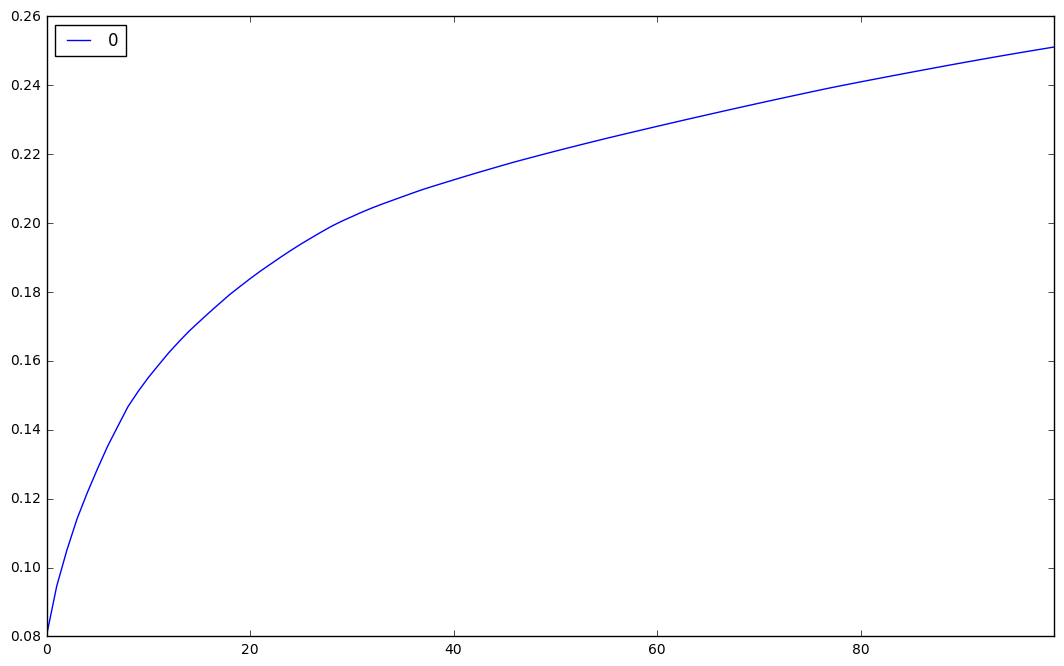

In [20]:
%matplotlib inline
pd.DataFrame(np.cumsum(svd.explained_variance_ratio_)).plot(figsize=(13, 8))

In [28]:
# this function will show you the axes on which a particular subreddit scores the highest/lowest
def pickOutComment(item):
    sorted_axes = embedded_coords[list(comments).index(item)].argsort()[::-1]
    return pd.DataFrame(comments[np.argsort(embedded_coords[:,sorted_axes], axis=0)[::-1]], columns=sorted_axes)

pickOutComment("notebook")

,0,17,76,75,62,83,78,74,54,8,...,3,35,13,18,25,2,26,7,4,1
0,notebook,rgbkrk,all of these will change again when the widge...,and the weight needs to be,there's a separate [jupyter/qtconsole](https:...,if there are other selected cells? So that it...,"will the """"tag toolbar"""" still be visible?""",and the backend deals with it fine. That's me...,fperez,design,...,nbgrader,"""Ok",takluyver,gnestor,2015-11-05 23:09:27,Carreau,2015-12-17 06:34:37,ellisonbg,minrk,
1,1350,but probably leave it to users to configure a...,"""and of course","""Just annoying because Binder is also down and...",we should just do it,it would move the mark (unless the cell were ...,it could still fail for some other reason tha...,2015-10-20 15:48:19,2017-02-01 14:42:11,2015-11-19 00:46:24,...,2016-04-19 20:06:09,thanks for the fast answer.,so it doesn't make sense to embed them into n...,"but it's stopping the tests from running.""",708,if someone can kindly point me in the right d...,879,"but it got changed.""","I think I see the bug ...""",apparently
2,2016-04-14 10:50:20,"but it is a bit of a papercut.""",2015-04-14 18:29:14,2016-09-23 02:10:18,but running `python example.py` with an activ...,and it wouldn't be surprising to users becaus...,save it and reload it? that made the error ap...,if this is still a problem for anyone else,@minrk I haven't seen this in quite a while ei...,2016-04-25 18:34:49,...,"""If you click the other """"breadcrumbs"""" links ...",2015-05-21 18:32:25,so they all see the same set of kernels. But ...,"which I'll work on shortly.""",2015-12-15 01:01:42,we should inject dir='ltr' by default on the ...,2016-03-15 13:10:16,"so I could use your help with that. """,we can rely on the env being active and use `...,students='students_course2')
3,"""Fixed in jupyter-client 4.1.1",giving us a place to store metadata that you ...,2015-04-14 17:12:32,"""cc @fperez",and I think we list directories in is_hidden ...,2015-10-27 21:54:08,"we’re happy i think!""",it turns out we can address this from the cli...,2017-02-01 14:33:43,"""Closing as all jupyterlab work is now happeni...",...,are those broken,2015-10-09 17:31:20,and it appears to be working as intended. Ret...,so maybe they didn't run 😮. I did receive a ...,thanks so much folks! We are indeed getting b...,"security-wise.""","""I reran the experiment from https://github.co...",since they are only npm packages but we need ...,which required a few small bugfixes not relat...,host='copano.tamu.edu:8000'
4,2015-10-08 11:43:38,I think I'd hold off on storing the state in ...,2016-11-17 14:29:19,2016-09-23 02:09:45,since it communicates actual information (we ...,"""> I like the no border too","it may well be hard.""",seems to prevent the `OPTIONS` preflight alto...,It's been a long time since I've been able to ...,2016-08-17 21:36:11,...,2016-04-19 20:02:23,2015-12-13 13:01:53,"IIRC.""","I have too much in my pipeline already.""",2015-12-14 22:21:25,ctrl on windows/linux. Meta is Alt/Option (II...,2016-03-15 15:10:50,I'm ready to publish 5.0.0 as soon as the blo...,"but that can be all in docs.""",in part
5,2015-10-08 10:38:07,and jupyter repo,"""@fperez this is already an opened issue.","""Still down.",and each system maps that to a kernel name. T...,which has boder.,but with so much complex software interacting,2015-10-05 21:25:35,"we can reopen it if people can reproduce it.""","""that looks great!",...,"""I am running off master from about 3 weeks ago.",seems that this is already a bit better: http...,"and +1 to collapsing $HOME to ~.""",you do make a really good point about tables ...,I really appreciate it :),"awaiting 5.0 release.""","""New PR : https://github.com/ellisonbg/noteboo...",if it is just for the dev version (but not me...,"markup).""",Action better than Action
6,2015-08-26 08:25:04,or a package co-published from the existing n...,2016-10-20 21:36:22,2016-09-23 02:07:00,we don't have any obvious way to communicate ...,"Though there is also the """"edit-mode"""" green",